### Squeeze and excitation


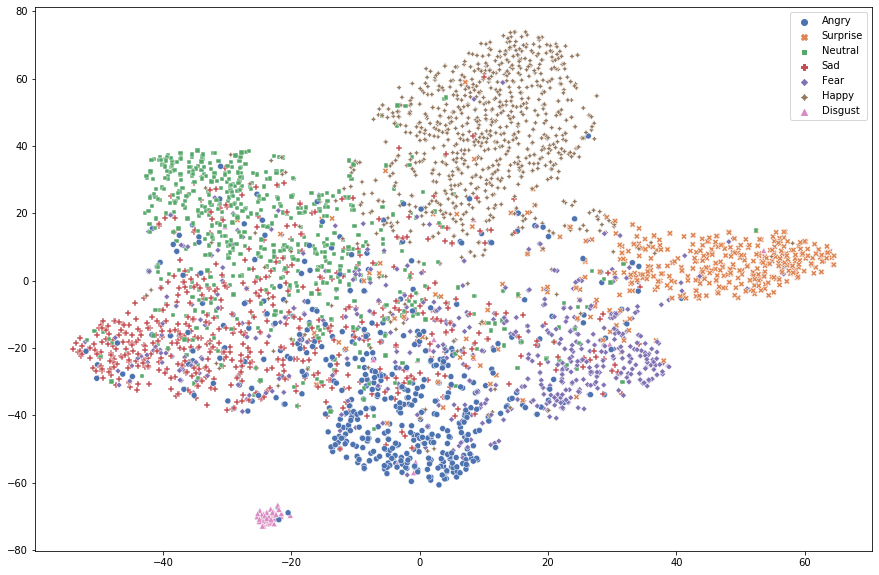

### Squeeze and excitation + Center loss

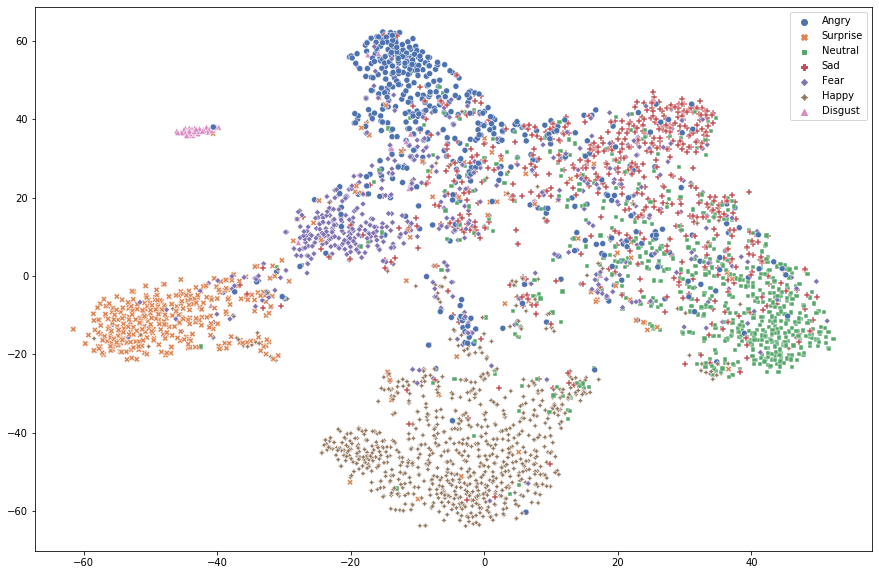

### Squeeze and excitation + island loss

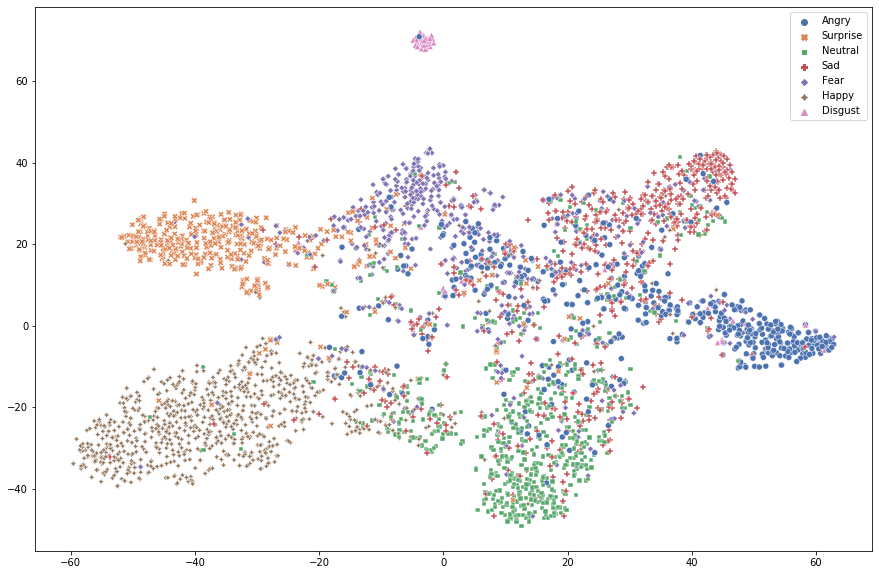

### SE + Multiatt

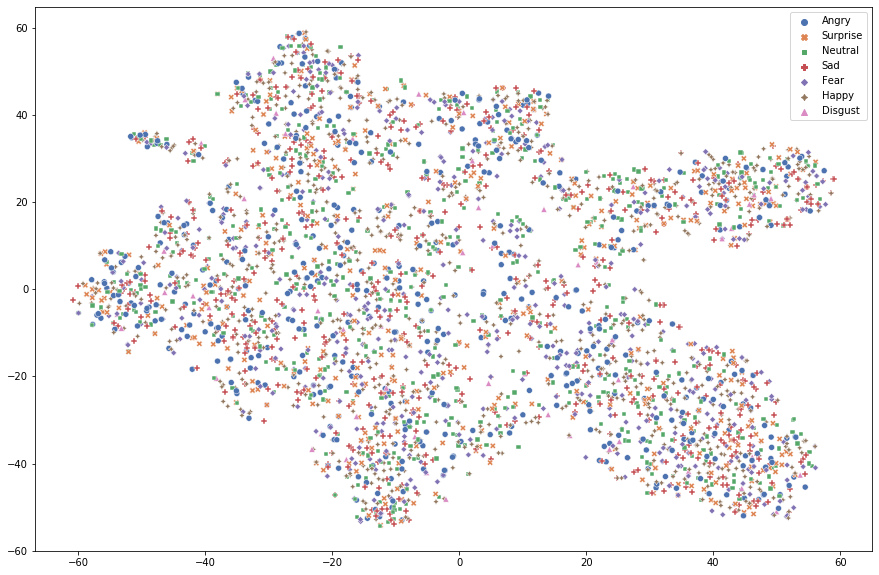

# Center loss

In [1]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [2]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
#         X = X.split()
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(48,48)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(image=X)['image']

#             X = torch.cat((X,X,X),0)

        return X, y

In [3]:
batch_size= 64

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']


train_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(64,64),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, p=0.5, border_mode=0, value=0),
#     A.RandomCrop(height=40, width=40),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])


test_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(64,64),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])

train_set = FERDataset(df_train, test_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
class SamplingDepth(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(SamplingDepth, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_channels, out_channels)
        self.dropout = nn.Dropout(dropout, inplace=False)
        
        # options
#         self.activation = nn.ReLU(inplace=True)
        self.activation = nn.Sigmoid()
#         self.activation = nn.Softmax()
        
    def forward(self, x):
        x = self.global_pool(x)
        x = nn.Flatten()(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.activation(x)
        
        return x
    
class SamplingSize(nn.Module):
    def __init__(self, size, depth):
        super(SamplingSize, self).__init__()
        
        self.size = size
        self.conv1x1 = nn.Conv2d(depth, 1, kernel_size=1, padding=0, stride=1)
        self.fc = nn.Linear(size[0]*size[1], size[0]*size[1])
        
         # options
        # self.activation = nn.ReLU(inplace=True)
        self.activation = nn.Sigmoid()
#         self.activation = nn.Softmax()

    def forward(self, x):
        x = self.conv1x1(x)
        x = nn.Flatten()(x)
        x = self.fc(x)
        x = self.activation(x)
        
        x = x.reshape(-1, 1, self.size[0], self.size[1])
        
        return x
        
MAX_LOGSTD = 10
class SamplingLatentSpace(nn.Module):
    def __init__(self, in_size, out_size):
        super(SamplingLatentSpace, self).__init__()
        
        
        self.in_size = in_size
        self.out_size = out_size

        self.relu = nn.ReLU()
        
        self.encode_conv = nn.Conv2d(in_size[0], out_size[0], kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        
        # self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.dim = out_size[0] * out_size[1] * out_size[2]
        self.fc_mu = nn.Linear(self.dim, self.dim)
        self.fc_logvar = nn.Linear(self.dim, self.dim)
        
        # self.decode_fc = nn.Linear(dim, fdim)
        # self.decode_conv = nn.ConvTranspose2d(mid_dim, in_size[0], kernel_size=3, padding=1)
        
    # def reparameterize(self, mu, logvar):
    #     std = torch.exp(logvar / 2)
    #     eps = torch.randn_like(std)
        
    #     return mu + std*eps

    def reparameterize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def kl_loss(self, mu, logstd):
        logstd = logstd.clamp(max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))
        
    def forward(self, x):
        
        # encode
        _x = self.encode_conv(x)
        _x = self.relu(_x)

        # _x = self.avgpool(x)
        _x = self.flatten(_x)
        
        x_mu = self.fc_mu(_x)
        x_logvar = self.fc_logvar(_x)
        
        # sampling
        z = self.reparameterize(x_mu, x_logvar)

        # reshape
        z = z.reshape(-1, self.out_size[0], self.out_size[1], self.out_size[2])
        
        return z, self.kl_loss(x_mu, x_logvar)
    
    
class SamplingAtt(nn.Module):
    def __init__(self, in_size, out_size):
        super(SamplingAtt, self).__init__()

        self.f_depth = SamplingDepth(in_size[0], out_size[0])
        self.f_spatial = SamplingSize((in_size[1], out_size[1]), out_size[0])
        self.f_sampling = SamplingLatentSpace(in_size, out_size)

        self.lambd = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def forward(self, x):
        x_depth = self.f_depth(x)
        x_spatial = self.f_spatial(x)

#         z, kl_loss = self.f_sampling(x)
        z = x
        out = (self.lambd*(z*x_depth[:,:,None,None])) + ((1 - self.lambd)*(z*x_spatial))

#         return out, kl_loss
        return out, 0.0

In [5]:
class pretrainedVGG_MultiAtt(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        
        super(pretrainedVGG_MultiAtt, self).__init__()
        pretrained = models.vgg16_bn(pretrained=True)
        
        self.pre_conv = nn.Conv2d(1, 3, kernel_size=3, padding=1, stride=1)
        self.block1 = pretrained.features[:7]
        self.block2 = pretrained.features[7:14]
        self.block3 = pretrained.features[14:24]
        self.block4 = pretrained.features[24:34]
#         self.block5 = pretrained.features[34:]
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.classifier = nn.Sequential(nn.Linear(in_features=512, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=7, bias=True))
        
        
        self.att3 = SamplingAtt((256, 8, 8), (256, 8, 8))
        self.att4 = SamplingAtt((512, 4, 4), (512, 4, 4))
        
        
    def forward(self, x):
        x = self.pre_conv(x)
        x = self.block1(x)
        
        x = self.block2(x)
        
        x = self.block3(x)
        x, kl3 = self.att3(x)
        
        x = self.block4(x)
        x, kl4 = self.att4(x)
        
#         x = self.block5(x)
#         x, kl5 = self.att5(x)
        
        x = self.avgpool(x)
        x = x.flatten(1)
        x = self.classifier(x)
        
        return x, torch.tensor([kl3, kl4]).sum()
        

In [6]:
device = torch.device('cuda')
model = pretrainedVGG_MultiAtt().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


In [7]:
# activation = {}
def get_activation(name):
    def hook(model, input, output):
        if name not in activation:
            activation[name] = []

        activation[name].append(output[0].detach())
    return hook

# gradients = {}
def get_gradient(name):
    def hook(model, in_grad, out_grad):
        gradients[name] = out_grad
        
    return hook


In [20]:
activation = {}
gradients = {}


device = torch.device('cpu')
model = torch.load('squeeze_excit_model/sqeeuze_excit_model.pt')
# model = torch.load('multiatt/vanilla_singlealphas_varmultiatt_4_0041_pretrainedmodel.pt')
model = model.to(device)
model.eval()

model.att4.register_forward_hook(get_activation('last_conv'))
# model.att4.register_backward_hook(get_gradient('last_conv'))



In [21]:
for k in val_loader:
    model(k[0].to(device))

In [91]:
import torch
import torch.nn as nn
import pickle

class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.cuda()
            
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

In [95]:
center_loss = CenterLoss(num_classes=7, feat_dim=512, use_gpu=True)
optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.001)

In [96]:
import pickle

train_feature = pickle.load(open('squeeze_excit_model/sqeeuze_excit_train_features.hdf5', 'rb'))
val_feature = pickle.load(open('squeeze_excit_model/sqeeuze_excit_val_features.hdf5', 'rb'))
test_feature = pickle.load(open('squeeze_excit_model/sqeeuze_excit_features.hdf5', 'rb'))

train_labels = torch.cat([k[1] for k in train_loader])
val_labels = torch.cat([k[1] for k in val_loader])
test_labels = torch.cat([k[1] for k in test_loader])

In [100]:
device = torch.device('cuda')
epochs = 500
batch_size = 256

train_steps = (train_feature.size(0) // batch_size)
val_steps = (val_feature.size(0) // batch_size)

print(train_feature.size(0) % batch_size)
print(val_feature.size(0) % batch_size)

for epoch in range(epochs):
    print('Epoch ', epoch + 1)
    
    rloss = 0.
    for i in range(train_steps + 1):
        inputs = train_feature[i*batch_size : (i+1)*batch_size]
        labels = train_labels[i*batch_size : (i+1)*batch_size]
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        loss = center_loss(inputs, labels)
        optimizer_centloss.zero_grad()
        loss.backward()
        optimizer_centloss.step()
        
        rloss += loss.item()
        
    print('- train loss: ', rloss / train_steps)
    
    rvalloss = 0.
    for i in range(val_steps + 1):
        inputs = val_feature[i*batch_size : (i+1)*batch_size]
        labels = val_labels[i*batch_size : (i+1)*batch_size]
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        loss = center_loss(inputs, labels)        
        rvalloss += loss.item()
    print('- val loss: ', rvalloss / val_steps)
        

37
5
Epoch  1
- train loss:  1.7496340870857239
- val loss:  3.101240566798619
Epoch  2
- train loss:  1.7496039324573107
- val loss:  3.101215498788016
Epoch  3
- train loss:  1.7495739960244723
- val loss:  3.1011906351361955
Epoch  4
- train loss:  1.7495442479848862
- val loss:  3.1011658906936646
Epoch  5
- train loss:  1.749514707497188
- val loss:  3.101141401699611
Epoch  6
- train loss:  1.749485352209636
- val loss:  3.1011170830045427
Epoch  7
- train loss:  1.749456223632608
- val loss:  3.1010930027280534
Epoch  8
- train loss:  1.7494272738695145
- val loss:  3.101068990571158
Epoch  9
- train loss:  1.7493985178215163
- val loss:  3.101045233862741
Epoch  10
- train loss:  1.749369973582881
- val loss:  3.1010216985430037
Epoch  11
- train loss:  1.7493416156087602
- val loss:  3.100998248372759
Epoch  12
- train loss:  1.7493134449635233
- val loss:  3.100975053650992
Epoch  13
- train loss:  1.7492854808058058
- val loss:  3.1009519951684132
Epoch  14
- train loss:  1.

- val loss:  3.0993871859141757
Epoch  111
- train loss:  1.7472921386361122
- val loss:  3.09937652519771
Epoch  112
- train loss:  1.7472778760961123
- val loss:  3.0993658815111433
Epoch  113
- train loss:  1.7472637136067664
- val loss:  3.0993553740637645
Epoch  114
- train loss:  1.7472496618117606
- val loss:  3.099344934735979
Epoch  115
- train loss:  1.7472356941018785
- val loss:  3.099334614617484
Epoch  116
- train loss:  1.7472218296357565
- val loss:  3.099324345588684
Epoch  117
- train loss:  1.7472080481903893
- val loss:  3.09931412764958
Epoch  118
- train loss:  1.747194382761206
- val loss:  3.0993040800094604
Epoch  119
- train loss:  1.7471807886447226
- val loss:  3.0992941175188338
Epoch  120
- train loss:  1.747167284999575
- val loss:  3.09928412096841
Epoch  121
- train loss:  1.7471538824694497
- val loss:  3.099274294716971
Epoch  122
- train loss:  1.7471405661531858
- val loss:  3.099264536585127
Epoch  123
- train loss:  1.7471273466944695
- val loss: 

- train loss:  1.7462056832654136
- val loss:  3.0986227989196777
Epoch  219
- train loss:  1.7461988106369972
- val loss:  3.098618643624442
Epoch  220
- train loss:  1.7461919763258524
- val loss:  3.0986143010003224
Epoch  221
- train loss:  1.7461851952331406
- val loss:  3.098610145705087
Epoch  222
- train loss:  1.7461784588439124
- val loss:  3.0986060074397495
Epoch  223
- train loss:  1.7461717682225364
- val loss:  3.098601835114615
Epoch  224
- train loss:  1.7461651297552245
- val loss:  3.0985977479389737
Epoch  225
- train loss:  1.746158524283341
- val loss:  3.0985936437334334
Epoch  226
- train loss:  1.7461519709655218
- val loss:  3.098589743886675
Epoch  227
- train loss:  1.7461454666086607
- val loss:  3.098585707800729
Epoch  228
- train loss:  1.7461389931184905
- val loss:  3.0985818079539706
Epoch  229
- train loss:  1.7461325664605414
- val loss:  3.098577925137111
Epoch  230
- train loss:  1.7461261940853936
- val loss:  3.0985740423202515
Epoch  231
- trai

- val loss:  3.098333784512111
Epoch  327
- train loss:  1.7456749422209603
- val loss:  3.0983323199408397
Epoch  328
- train loss:  1.7456716820597649
- val loss:  3.0983309064592635
Epoch  329
- train loss:  1.74566842934915
- val loss:  3.0983294589178905
Epoch  330
- train loss:  1.7456652064408575
- val loss:  3.098328028406416
Epoch  331
- train loss:  1.7456619952406203
- val loss:  3.098326631954738
Epoch  332
- train loss:  1.7456588074564934
- val loss:  3.098325286592756
Epoch  333
- train loss:  1.7456556494746889
- val loss:  3.0983239582606723
Epoch  334
- train loss:  1.745652508522783
- val loss:  3.0983225788388933
Epoch  335
- train loss:  1.7456493920513563
- val loss:  3.0983212675367082
Epoch  336
- train loss:  1.7456462851592474
- val loss:  3.0983199732644215
Epoch  337
- train loss:  1.7456432208418846
- val loss:  3.0983186619622365
Epoch  338
- train loss:  1.7456401597176279
- val loss:  3.0983173847198486
Epoch  339
- train loss:  1.745637127331325
- val l

- train loss:  1.7454223845686232
- val loss:  3.098248226302011
Epoch  437
- train loss:  1.745420828461647
- val loss:  3.098247936793736
Epoch  438
- train loss:  1.7454192755477769
- val loss:  3.0982477154050554
Epoch  439
- train loss:  1.745417750307492
- val loss:  3.0982474258967807
Epoch  440
- train loss:  1.7454162303890501
- val loss:  3.098247136388506
Epoch  441
- train loss:  1.7454147030200278
- val loss:  3.098246932029724
Epoch  442
- train loss:  1.7454131980027472
- val loss:  3.0982467447008406
Epoch  443
- train loss:  1.745411710015365
- val loss:  3.0982464381626675
Epoch  444
- train loss:  1.7454102230923516
- val loss:  3.0982461997440884
Epoch  445
- train loss:  1.7454087563923426
- val loss:  3.0982459613255093
Epoch  446
- train loss:  1.7454072854348592
- val loss:  3.098245773996626
Epoch  447
- train loss:  1.7454058272497994
- val loss:  3.098245552607945
Epoch  448
- train loss:  1.7454043754509516
- val loss:  3.098245314189366
Epoch  449
- train l

In [103]:
center_loss.centers

Parameter containing:
tensor([[ 0.0077,  0.0057,  0.0052,  ...,  0.2817,  0.0251,  0.0256],
        [ 0.0029,  0.0019, -0.0041,  ...,  0.0170,  0.0071,  0.0096],
        [ 0.0130,  0.0150,  0.0026,  ...,  0.0271,  0.2065,  0.0196],
        ...,
        [ 0.0045,  0.0030,  0.0067,  ...,  0.0478,  0.0474,  0.0323],
        [ 0.2854,  0.3003,  0.0053,  ...,  0.0211,  0.1906,  0.0344],
        [ 0.0141,  0.0145,  0.0744,  ...,  0.0283,  0.1776,  0.2850]],
       device='cuda:0', requires_grad=True)

In [19]:
a[9:12]

tensor([0.3792])

In [1]:
import torch
a = torch.rand(12)
a

tensor([0.1751, 0.9918, 0.6117, 0.8720, 0.1922, 0.2680, 0.6993, 0.6720, 0.3510,
        0.0319, 0.5960, 0.4937])

In [3]:
a /= a.norm(2)
a

tensor([0.0884, 0.5008, 0.3089, 0.4403, 0.0971, 0.1353, 0.3531, 0.3394, 0.1772,
        0.0161, 0.3010, 0.2493])